# **Environment Setting**

python -m venv .venv 

source .venv/bin/activate # macOS/Linux

.\.venv\Scripts\activate # # Windows

pip install -U pip
  pip install xgboost scikit-learn pandas numpy

### **Check interpreter**

VS Code → Command Palette → Python: Select Interpreter → select .venv


### **Test** 

python -c "import xgboost; print(xgboost.__version__)"

# **Data Cleaning and Data Preprocessing**

In [5]:
# ============================================================
# IMPORT LIBRARIES
# ------------------------------------------------------------
# pandas  : tabular data manipulation (DataFrames)
# numpy   : numerical operations and array utilities
# matplotlib.pyplot : plotting / visualisation
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- scikit-learn modules ---
# train_test_split     : split data into training and test sets
# ColumnTransformer    : apply different transformations to different column groups
# OneHotEncoder        : encode categorical variables as binary dummy columns
# StandardScaler       : standardise numeric features to zero-mean, unit-variance
# Pipeline             : chain preprocessing + model into a single estimator
# StratifiedKFold      : k-fold CV that preserves the class ratio in each fold
# cross_validate       : run CV and return scores dict
# f1_score             : harmonic mean of precision & recall (positive class)
# roc_auc_score        : area under the ROC curve
# classification_report: per-class precision, recall, F1, support
# confusion_matrix     : 2x2 TP/FP/FN/TN table
# permutation_importance: model-agnostic feature importance via random shuffling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# --- Classifiers ---
# LogisticRegression   : linear probabilistic baseline classifier
# RandomForestClassifier: ensemble of decision trees (bagging)
# XGBClassifier        : gradient-boosted trees (XGBoost library)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [6]:
# ============================================================
# LOAD DATASET
# ------------------------------------------------------------
# The UCI Bank Marketing dataset (bank-full.csv) contains
# direct phone-call marketing campaign data from a Portuguese
# bank.  The target variable 'y' indicates whether the client
# subscribed to a term deposit (yes/no).
#
# Important: the file uses semicolons (;) as delimiters instead
# of the more common comma, so we pass sep=";" explicitly.
# ============================================================

DATA_PATH = "bank-full.csv"   # path to the raw data file

# Read CSV with semicolon separator into a pandas DataFrame
df = pd.read_csv(DATA_PATH, sep=";")  # semicolon-separated format


In [7]:
# Display the first 5 rows to get a quick look at column names,
# data types, and representative values.
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
# Display the last 5 rows to confirm the file was read completely
# and to check for any trailing artefacts or unexpected values.
df.tail()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [9]:
# ============================================================
# INITIAL DATASET INSPECTION
# ------------------------------------------------------------
# Quick sanity checks before cleaning:
#   1. Shape    – total rows and columns
#   2. Columns  – verify expected feature names are present
#   3. Info     – dtypes and non-null counts per column
#   4. Target distribution – check for class imbalance
# ============================================================

print("Shape:", df.shape)                        # (rows, cols)
print("Columns:", df.columns.tolist())            # list of column names
print("Basic Info", df.info())                    # dtype + non-null counts

# Count how many clients subscribed (yes) vs. did not (no)
print("\nTarget distribution (counts):\n",
      df["y"].value_counts())

# Show the same as proportions (rates) – useful for spotting imbalance
print("\nTarget distribution (rate):\n",
      df["y"].value_counts(normalize=True).round(4))


Shape: (45211, 17)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null 

In [10]:
# ============================================================
# CHECK FOR MISSING VALUES
# ------------------------------------------------------------
# isna() returns a boolean DataFrame; .sum() counts True per column.
# Sorting descending and showing the top 10 highlights the most
# problematic columns first.
# ============================================================

print("\nMissing values per column:\n",
      df.isna().sum().sort_values(ascending=False).head(10))



Missing values per column:
 age         0
day         0
poutcome    0
previous    0
pdays       0
campaign    0
duration    0
month       0
contact     0
job         0
dtype: int64


In [11]:
# ============================================================
# CHECK FOR DUPLICATE ROWS
# ------------------------------------------------------------
# duplicated() marks every row that is a full duplicate of an
# earlier row. Summing gives the total count of duplicate rows.
# ============================================================

print("\nThe number column of duplicated values:\n",
      df.duplicated().sum())



The number column of duplicated values:
 0


In [12]:
# ============================================================
# COUNT 'unknown' CATEGORY VALUES
# ------------------------------------------------------------
# In this dataset several categorical columns use the string
# 'unknown' as a placeholder for missing information rather than
# NaN.  We count them per column so we can decide later whether
# to impute, flag, or keep them as a separate category.
# The target column 'y' is excluded from this check.
# ============================================================

# Select all object-dtype (string/categorical) columns
obj_cols = df.select_dtypes(include="object").columns

# Count 'unknown' occurrences in each categorical column (except target)
unknown_counts = {c: (df[c] == "unknown").sum()
                  for c in obj_cols if c != "y"}

# Convert to Series and sort for easy reading
unknown_counts = pd.Series(unknown_counts).sort_values(ascending=False)
print("\nTop 'unknown' counts:\n", unknown_counts.head(10))



Top 'unknown' counts:
 poutcome     36959
contact      13020
education     1857
job            288
marital          0
default          0
housing          0
loan             0
month            0
dtype: int64


In [13]:
# ============================================================
# NUMERIC FEATURE SANITY CHECKS
# ------------------------------------------------------------
# A quick look at min, median (50%), and max helps us spot:
#   - impossible negative values  (e.g. negative age)
#   - extreme outliers that may distort model training
#   - columns that need special treatment (e.g. pdays = -1 for 'not contacted')
# ============================================================

# Identify all numeric columns automatically
num_cols = df.select_dtypes(include=[np.number]).columns

# Show a compact summary: min / median / max for each numeric feature
print("\nNumeric summary (selected):\n",
      df[num_cols].describe().T[["min", "50%", "max"]].head(10))



Numeric summary (selected):
              min    50%       max
age         18.0   39.0      95.0
balance  -8019.0  448.0  102127.0
day          1.0   16.0      31.0
duration     0.0  180.0    4918.0
campaign     1.0    2.0      63.0
pdays       -1.0   -1.0     871.0
previous     0.0    0.0     275.0


In [14]:
# ============================================================
# DROP MISSING VALUES (if any)
# ------------------------------------------------------------
# The inspection above showed zero NaN values in this dataset,
# so dropna() is not needed.  The commented-out code is kept
# as a reference template for datasets that do have NaNs.
# ============================================================

# df_clean = df.dropna()  # Not needed here – no NaN values found


In [15]:
# ============================================================
# CREATE A WORKING COPY OF THE ORIGINAL DATAFRAME
# ------------------------------------------------------------
# We always work on a copy (df_clean) so the raw DataFrame (df)
# remains unmodified and can be used for reference or re-runs
# without reloading the file.
# ============================================================

df_clean = df.copy()   # deep copy – changes to df_clean will not affect df


In [16]:
# ============================================================
# REMOVE DATA LEAKAGE FEATURE: 'duration'
# ------------------------------------------------------------
# 'duration' is the length of the last phone call in seconds.
# It is highly predictive of the target BUT it is only known
# AFTER the call ends – it cannot be used to decide whether
# to place the call in the first place.
#
# Including it would cause unrealistically high scores during
# training yet the feature would be unavailable at inference
# time, making the model useless in production.  This type of
# issue is called 'target leakage' and must be removed.
#
# Reference: UCI dataset documentation recommends dropping it
# for realistic predictive modelling.
# ============================================================

if "duration" in df_clean.columns:
    df_clean = df_clean.drop(columns=["duration"])  # remove the leaky column


In [17]:
# ============================================================
# REMOVE DUPLICATE ROWS
# ------------------------------------------------------------
# Even though the raw data showed very few (or zero) duplicates,
# we perform the drop here as a defensive step.  Printing the
# before/after row count confirms how many rows (if any) were
# removed.
# ============================================================

before = df_clean.shape[0]                    # row count before deduplication
df_clean = df_clean.drop_duplicates()         # keep only the first occurrence
after  = df_clean.shape[0]                   # row count after deduplication
print(f"\nDuplicates removed: {before - after}")



Duplicates removed: 16


In [18]:
# ============================================================
# CONVERT 'day' FROM NUMERIC TO CATEGORICAL
# ------------------------------------------------------------
# 'day' holds the day-of-month (1–31) the client was last
# contacted.  Although stored as an integer, it is conceptually
# a label (there is no meaningful ordinal relationship between
# day 1 and day 31 for this task).
#
# Casting to 'object' dtype ensures it is treated as a
# categorical feature by the preprocessing pipeline and will
# be one-hot encoded rather than scaled.
# ============================================================

df_clean["day"] = df_clean["day"].astype("object")  # treat day-of-month as a category


In [19]:
# ============================================================
# DEFINE FEATURE MATRIX (X) AND TARGET VECTOR (y)
# ------------------------------------------------------------
# X  : all columns except the target variable 'y'
# y  : binary label – 1 if client subscribed (yes), 0 otherwise
#
# Encoding 'yes'→1 and 'no'→0 allows scikit-learn classifiers
# to work with integer labels and lets us interpret probabilities
# as P(subscription = yes).
# ============================================================

X = df_clean.drop(columns=["y"])               # feature matrix (all columns minus target)
y = df_clean["y"].map({"no": 0, "yes": 1})    # encode target: yes=1, no=0


In [20]:
# ============================================================
# TRAIN / TEST SPLIT  (80% train, 20% test)
# ------------------------------------------------------------
# stratify=y  : preserves the original class ratio in both
#               splits, which is important with imbalanced data.
# random_state: fixed seed for reproducibility.
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20 % held out for final evaluation
    random_state=42,    # fixed seed – reproducible splits
    stratify=y          # maintain class balance in both sets
)

# Confirm shapes and class balance are preserved in both sets
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train positive rate:", round(y_train.mean(), 3),
      " Test positive rate:", round(y_test.mean(), 3))


Train shape: (36156, 15)  Test shape: (9039, 15)
Train positive rate: 0.117  Test positive rate: 0.117


In [21]:
# ============================================================
# BUILD PREPROCESSING PIPELINE
# ------------------------------------------------------------
# We apply different transformations depending on column type:
#
#   Numeric features  → StandardScaler
#       Centres each feature to mean=0 and std=1 so that
#       Logistic Regression is not dominated by large-scale
#       variables (e.g. 'balance').
#
#   Categorical features → OneHotEncoder
#       Converts each category to a binary indicator column.
#       handle_unknown='ignore' silently assigns an all-zero
#       vector to any unseen category at test time.
#       sparse_output=False returns a dense NumPy array for
#       compatibility with all downstream estimators.
#
# Note on 'unknown' values:
#   Cells coded as 'unknown' are kept as their own category;
#   OneHotEncoder handles them naturally, creating an
#   'unknown' indicator column.
# ============================================================

# Automatically separate categorical and numerical column names
categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features   = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:",   numerical_features)

# Build the column-wise transformer
preprocess = ColumnTransformer(
    transformers=[
        # Scale numeric columns
        ("num", StandardScaler(), numerical_features),
        # One-hot encode categorical columns
        ("cat",
         OneHotEncoder(handle_unknown="ignore", sparse_output=False),
         categorical_features),
    ],
    remainder="drop"   # discard any columns not explicitly listed
)

# Fit on the training data to confirm the transformer works correctly
_ = preprocess.fit_transform(X_train)
print("Preprocess OK")


Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']
Numerical features: ['age', 'balance', 'campaign', 'pdays', 'previous']
Preprocess OK


In [22]:
#Recheck the "duration" to make sure that it is not included
print("duration in X?", "duration" in X.columns)  # should be False
print("Numerical features:", numerical_features)

duration in X? False
Numerical features: ['age', 'balance', 'campaign', 'pdays', 'previous']


# **Exploratory Data Analysis (EDA)**

In [23]:
# ============================================================
# HELPER FUNCTION: SUBSCRIPTION RATE TABLE
# ------------------------------------------------------------
# rate_table() computes the proportion of 'yes' (subscribed)
# for each unique value of a given column, then returns the
# top_n rows sorted by rate (highest first).
#
# Arguments
#   df     : the DataFrame to analyse
#   col    : categorical column to group by
#   top_n  : maximum number of rows to return (default 10)
#
# Returns
#   A pandas Series: index = category values, values = rates
# ============================================================

def rate_table(df, col, top_n=10):
    tmp = (
        df.groupby(col)["y"]
          # compute the fraction of 'yes' within each group
          .apply(lambda s: (s == "yes").mean())
          .sort_values(ascending=False)   # highest rate first
          .head(top_n)
    )
    return tmp


In [24]:
# ============================================================
# EXPLORATORY DATA ANALYSIS – TARGET CLASS BALANCE
# ------------------------------------------------------------
# Understanding class imbalance is critical for model design.
# If 'no' vastly outnumbers 'yes', a naive classifier that
# always predicts 'no' achieves high accuracy but zero recall
# for the positive class.  We address imbalance via
# class_weight / scale_pos_weight in the model definitions.
# ============================================================

y_counts = df_clean["y"].value_counts()              # raw counts
y_rate   = df_clean["y"].value_counts(normalize=True) # proportions

print("Overall target counts:\n", y_counts)
print("\nOverall target rate:\n", y_rate.round(4))


Overall target counts:
 y
no     39906
yes     5289
Name: count, dtype: int64

Overall target rate:
 y
no     0.883
yes    0.117
Name: proportion, dtype: float64


In [25]:
# ============================================================
# NUMERIC FEATURE DISTRIBUTIONS AND OUTLIER DETECTION
# ------------------------------------------------------------
# Reviewing quartiles and extremes helps identify:
#   - 'balance'   : can be negative (overdraft accounts)
#   - 'pdays'     : -1 means the client was never previously
#                   contacted (sentinel value, not a real day)
#   - 'campaign'  : very high values may indicate unusually
#                   targeted contacts worth capping
# ============================================================

# Subset of numeric columns of interest for this analysis
num_cols = ["age", "balance", "campaign", "pdays", "previous"]

# Show a five-number summary for each selected numeric feature
print("\nNumeric summary:\n",
      df_clean[num_cols].describe().T[["min","25%","50%","75%","max"]])



Numeric summary:
              min   25%    50%     75%       max
age         18.0  33.0   39.0    48.0      95.0
balance  -8019.0  72.0  449.0  1428.0  102127.0
campaign     1.0   1.0    2.0     3.0      63.0
pdays       -1.0  -1.0   -1.0    -1.0     871.0
previous     0.0   0.0    0.0     0.0     275.0


In [26]:
# ============================================================
# CHECK FOR SKEW AND EXTREME VALUES (99th PERCENTILE)
# ------------------------------------------------------------
# Comparing the 99th percentile to the maximum reveals extreme
# outliers.  A large gap between q99 and max may indicate
# values that need capping (winsorisation) to prevent
# tree-based models from creating very deep, narrow splits.
# ============================================================

for c in num_cols:
    q99 = df_clean[c].quantile(0.99)           # 99th percentile
    print(f"{c}: 99th percentile={q99}, max={df_clean[c].max()}")


age: 99th percentile=71.0, max=95
balance: 99th percentile=13166.259999999951, max=102127
campaign: 99th percentile=16.0, max=63
pdays: 99th percentile=370.0, max=871
previous: 99th percentile=9.0, max=275


In [27]:
# ============================================================
# SUBSCRIPTION RATE BY KEY CATEGORICAL VARIABLES
# ------------------------------------------------------------
# Inspecting the subscription rate per category value shows
# which levels are most predictive of a positive outcome.
# For example:
#   poutcome='success'  → very high subscription rate
#   contact='cellular'  → higher rate than 'telephone'
#   month='mar','dec'   → typically higher seasonal rates
# ============================================================

# Full list of categorical columns (for reference)
cat_cols = ["poutcome", "contact", "month", "job",
            "education", "marital", "housing", "loan",
            "default", "day"]

# Print subscription rates for selected high-signal columns
for c in ["poutcome", "contact", "month", "housing", "loan", "default"]:
    print(f"\nSubscription rate by {c}:\n",
          rate_table(df_clean, c, top_n=20).round(4))



Subscription rate by poutcome:
 poutcome
success    0.6473
other      0.1668
failure    0.1261
unknown    0.0917
Name: y, dtype: float64

Subscription rate by contact:
 contact
cellular     0.1493
telephone    0.1342
unknown      0.0407
Name: y, dtype: float64

Subscription rate by month:
 month
mar    0.5199
dec    0.4673
sep    0.4646
oct    0.4377
apr    0.1968
feb    0.1665
aug    0.1103
jun    0.1022
nov    0.1015
jan    0.1012
jul    0.0910
may    0.0672
Name: y, dtype: float64

Subscription rate by housing:
 housing
no     0.1671
yes    0.0770
Name: y, dtype: float64

Subscription rate by loan:
 loan
no     0.1266
yes    0.0668
Name: y, dtype: float64

Subscription rate by default:
 default
no     0.1180
yes    0.0638
Name: y, dtype: float64


In [28]:
# ============================================================
# COMPARE NUMERIC FEATURES BY TARGET CLASS
# ------------------------------------------------------------
# Computing mean and median for each numeric feature, split by
# target class (yes / no), reveals whether subscribers tend to
# differ in balance, age, or number of contacts.
# Large differences between means suggest strong predictors.
# ============================================================

# Aggregate mean and median for each numeric feature, grouped by target
group_stats = df_clean.groupby("y")[num_cols].agg(["mean", "median"])
print("\nNumeric feature comparison by y:\n", group_stats)



Numeric feature comparison by y:
            age             balance         campaign             pdays         \
          mean median         mean median      mean median       mean median   
y                                                                              
no   40.840525   39.0  1304.237684  417.0  2.846539    2.0  36.436375   -1.0   
yes  41.670070   38.0  1804.267915  733.0  2.141047    2.0  68.702968   -1.0   

     previous         
         mean median  
y                     
no   0.502356    0.0  
yes  1.170354    0.0  


In [29]:
# ============================================================
# PAIRWISE CORRELATION AMONG NUMERIC FEATURES
# ------------------------------------------------------------
# High correlations between features can lead to redundant
# predictors (multicollinearity), which may inflate variance
# in linear models.  Tree-based models are less sensitive but
# still benefit from knowing which features carry similar info.
# Note: 'y' is excluded because it is categorical.
# ============================================================

# Pearson correlation matrix for numeric features only
corr = df_clean[num_cols].corr()
print("\nCorrelation among numeric features:\n", corr.round(3))



Correlation among numeric features:
             age  balance  campaign  pdays  previous
age       1.000    0.098     0.005 -0.024     0.001
balance   0.098    1.000    -0.015  0.003     0.017
campaign  0.005   -0.015     1.000 -0.089    -0.033
pdays    -0.024    0.003    -0.089  1.000     0.455
previous  0.001    0.017    -0.033  0.455     1.000


In [30]:
# ============================================================
# SUBSCRIPTION RATE BY MONTH
# ------------------------------------------------------------
# Seasonality can be a strong signal in marketing data.
# Identifying high-rate months (e.g. March, December) helps
# understand campaign timing effects and potential feature
# importance of 'month'.
# ============================================================

# Compute the fraction of 'yes' for each calendar month
month_rates = (
    df_clean.groupby("month")["y"]
            .apply(lambda s: (s == "yes").mean())
            .sort_values(ascending=False)   # best months first
)
print("\nMonth subscription rates (all):\n", month_rates.round(4))



Month subscription rates (all):
 month
mar    0.5199
dec    0.4673
sep    0.4646
oct    0.4377
apr    0.1968
feb    0.1665
aug    0.1103
jun    0.1022
nov    0.1015
jan    0.1012
jul    0.0910
may    0.0672
Name: y, dtype: float64


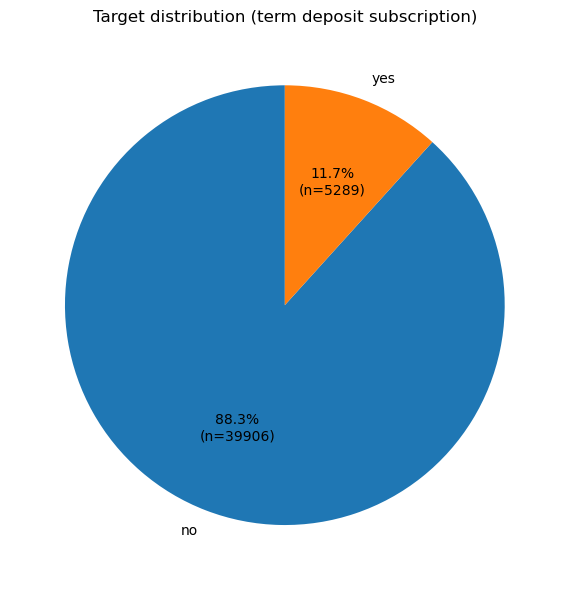

In [53]:
# ============================================================
# VISUALISATION – TARGET CLASS DISTRIBUTION (PIE CHART)
# ------------------------------------------------------------
# A pie chart gives an immediate visual impression of the
# class imbalance.  The custom autopct function adds both the
# percentage and the absolute count to each slice so readers
# do not need to mentally convert proportions.
# ============================================================

# Count each class and extract labels / sizes for plotting
counts = df_clean["y"].value_counts()
labels = counts.index.tolist()
sizes  = counts.values

# Custom formatter that shows both percentage and raw count
def autopct_format(values):
    total = sum(values)
    def _autopct(pct):
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n(n={count})"
    return _autopct

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=autopct_format(sizes),   # show % and count
    startangle=90                    # rotate so 'no' starts at the top
)
plt.title("Target distribution (term deposit subscription)")
plt.tight_layout()
plt.show()


In [32]:
# ============================================================
# HELPER FUNCTION: SUBSCRIPTION RATE BAR CHART
# ------------------------------------------------------------
# plot_rate() draws a bar chart showing P(y=yes) for each
# unique value of the specified column.
#
# Arguments
#   col    : name of the categorical column to plot
#   top_n  : if set, limits to the top_n most frequent values
#            (useful for high-cardinality columns like 'day')
# ============================================================

def plot_rate(col, top_n=None):
    # Compute subscription rate per category value
    rates = df_clean.groupby(col)["y"].apply(lambda s: (s == "yes").mean())

    if top_n:
        # Restrict to the most frequent values to avoid a cluttered chart
        top   = df_clean[col].value_counts().head(top_n).index
        rates = rates.loc[top]

    # Sort descending and draw bar chart
    rates.sort_values(ascending=False).plot(kind="bar")
    plt.ylabel("Subscription rate (P(y=yes))")
    plt.title(f"Subscription rate by {col}")
    plt.show()


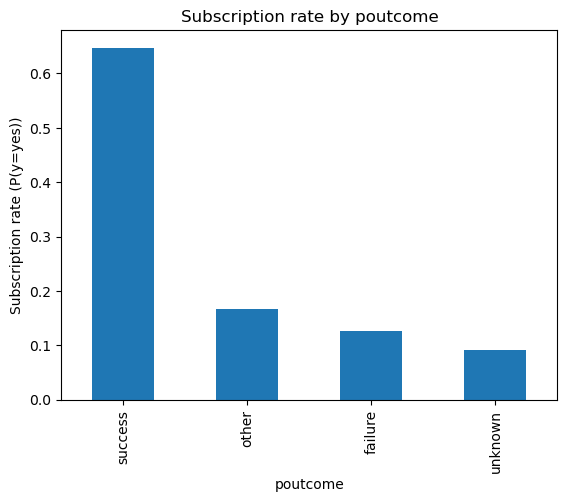

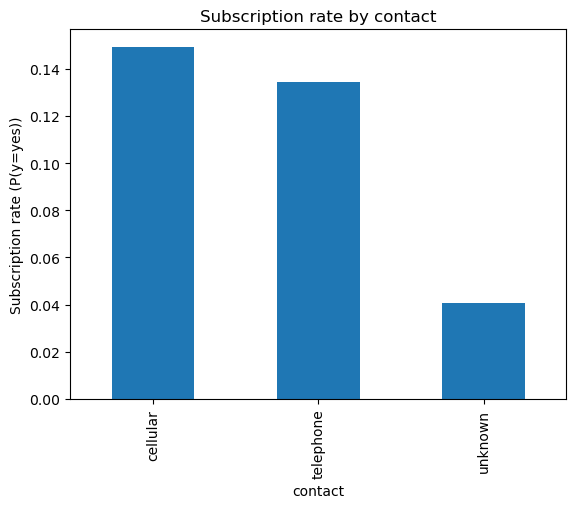

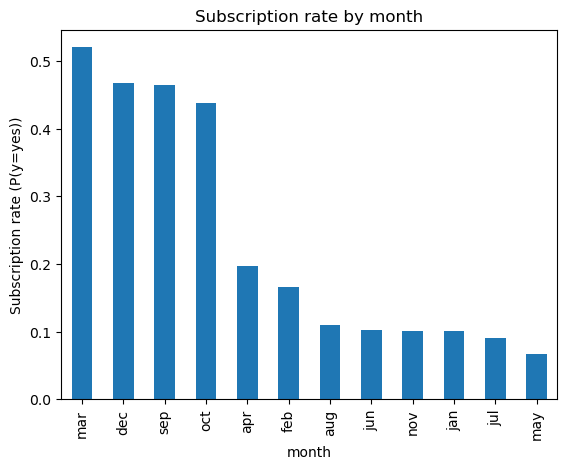

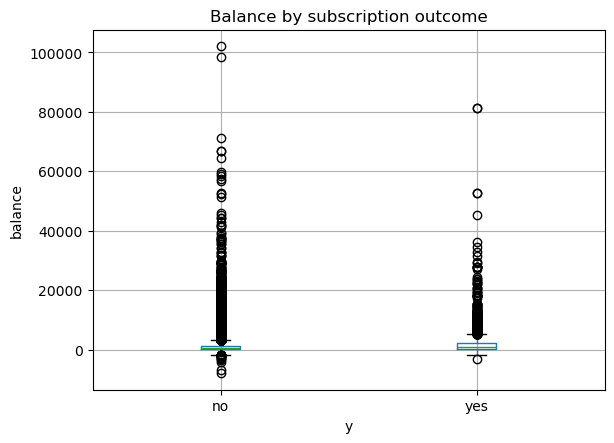

In [ ]:
# ============================================================
# EXPLORATORY VISUALISATIONS – KEY CATEGORICAL AND NUMERIC
# ------------------------------------------------------------
# 1. poutcome: outcome of previous campaign – 'success' strongly
#    predicts another subscription.
# 2. contact : communication channel – cellular vs. telephone.
# 3. month   : call month – shows seasonality patterns.
# 4. balance boxplot: compares account balance distributions
#    between subscribers and non-subscribers.
# ============================================================

# Bar chart: subscription rate by previous campaign outcome
plot_rate("poutcome")

# Bar chart: subscription rate by contact channel and by month
plot_rate("contact")
plot_rate("month")

# Boxplot: account balance distribution split by target class
df_clean.boxplot(column="balance", by="y")
plt.title("Balance by subscription outcome")
plt.suptitle("")    # remove the default pandas suptitle
plt.xlabel("y")
plt.ylabel("balance")
plt.show()


# **Modelling approach**

This section compares three classification models for the pre-call term-deposit prediction task:
  - Loistic Regression
  - Random Forest
  - XGBoost

In [34]:
# ============================================================
# MODEL DEFINITION, CROSS-VALIDATION, AND TEST EVALUATION
# ============================================================

# ------------------------------------------------------------
# 1. DEFINE THREE CANDIDATE CLASSIFIERS
# ------------------------------------------------------------

# --- Logistic Regression (baseline) ---
# max_iter=2000     : more iterations so the solver converges
#                     on high-dimensional one-hot encoded data
# class_weight='balanced': upweights the minority class (yes)
#                     automatically by n_samples / (n_classes * n_y)
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",   # compensate for class imbalance
    random_state=42
)

# --- Random Forest ---
# n_estimators=400           : 400 trees – enough for stable estimates
# min_samples_leaf=2         : reduce overfitting by requiring ≥2
#                              samples in every leaf
# class_weight='balanced_subsample': re-weights classes per tree
#                                    using each bootstrap sample
# n_jobs=-1                  : use all available CPU cores
rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"   # per-bootstrap class weighting
)

# --- XGBoost ---
# scale_pos_weight = neg / pos ≈ 0.883 / 0.117 ≈ 7.5
#   This tells XGBoost to upweight positive samples proportionally,
#   which is the XGBoost-native way to handle class imbalance.
# n_estimators=400, learning_rate=0.05: more trees with small
#   steps to prevent overfitting
# max_depth=4   : shallow trees to reduce variance
# subsample=0.8, colsample_bytree=0.8: stochastic training –
#   sample 80 % of rows and columns per tree for regularisation
# reg_lambda=1.0: L2 regularisation on leaf weights
# tree_method='hist': faster histogram-based tree construction
scale_pos_weight = 0.883 / 0.117   # ratio of negative to positive samples

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist",             # efficient histogram method
    scale_pos_weight=scale_pos_weight  # class imbalance correction
)

# Collect all models in a dict for easy iteration
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

# ------------------------------------------------------------
# 2. STRATIFIED K-FOLD CROSS-VALIDATION ON THE TRAINING SET
# ------------------------------------------------------------
# StratifiedKFold(n_splits=5): 5-fold CV that maintains the
#   class ratio in each fold – essential with imbalanced data.
# Scoring: F1 (harmonic mean of precision & recall for positive
#   class) and ROC-AUC (discrimination ability across thresholds).
# We wrap each model in a Pipeline so that preprocessing is
#   fit only on the training folds and applied to validation
#   folds, preventing data leakage.

cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"f1": "f1", "roc_auc": "roc_auc"}

cv_rows = []  # will store per-model CV results
pipes   = {}  # will store fitted Pipeline objects

for name, model in models.items():
    # Chain preprocessing + classifier into a single Pipeline
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),   # scale + one-hot encode
        ("model", model)              # classifier
    ])
    pipes[name] = pipe

    # Run 5-fold CV; return_train_score=False saves computation
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )

    # Store mean and std of each metric across folds
    cv_rows.append({
        "Model": name,
        "CV F1 (mean)": scores["test_f1"].mean(),
        "CV F1 (std)": scores["test_f1"].std(),
        "CV ROC-AUC (mean)": scores["test_roc_auc"].mean(),
        "CV ROC-AUC (std)": scores["test_roc_auc"].std(),
    })

# Display CV results sorted by mean F1 (best model first)
cv_results = pd.DataFrame(cv_rows).sort_values("CV F1 (mean)", ascending=False)
print("\nCross-validation results (train set):")
print(cv_results.round(4))

# ------------------------------------------------------------
# 3. FIT ON FULL TRAINING SET AND EVALUATE ON HELD-OUT TEST SET
# ------------------------------------------------------------
# After CV we refit each pipeline on ALL training data and
# produce final scores on the unseen test set.

test_rows = []  # per-model test metrics
fitted    = {}  # fully trained Pipeline objects

for name, pipe in pipes.items():
    pipe.fit(X_train, y_train)  # fit on full training set
    fitted[name] = pipe

    y_pred  = pipe.predict(X_test)                # hard class predictions
    y_proba = pipe.predict_proba(X_test)[:, 1]    # P(y=1) for AUC

    test_rows.append({
        "Model": name,
        "Test F1": f1_score(y_test, y_pred),
        "Test ROC-AUC": roc_auc_score(y_test, y_proba),
    })

# Rank models by Test F1
test_results = pd.DataFrame(test_rows).sort_values("Test F1", ascending=False)
print("\nTest set results:")
print(test_results.round(4))

# ------------------------------------------------------------
# 4. DETAILED DIAGNOSTICS FOR THE BEST MODEL (by Test F1)
# ------------------------------------------------------------

# Select the top-ranked model
best_name = test_results.iloc[0]["Model"]
best_pipe = fitted[best_name]
print(f"\nBest model by Test F1: {best_name}")

best_pred = best_pipe.predict(X_test)

# Confusion matrix: rows = true class, cols = predicted class
print("\nConfusion matrix:")
print(confusion_matrix(y_test, best_pred))

# Full per-class precision, recall, F1, and support
print("\nClassification report:")
print(classification_report(y_test, best_pred, digits=4))



Cross-validation results (train set):
                 Model  CV F1 (mean)  CV F1 (std)  CV ROC-AUC (mean)  \
1        Random Forest        0.4487       0.0135             0.7907   
2              XGBoost        0.4363       0.0102             0.7961   
0  Logistic Regression        0.3854       0.0052             0.7697   

   CV ROC-AUC (std)  
1            0.0091  
2            0.0106  
0            0.0083  

Test set results:
                 Model  Test F1  Test ROC-AUC
1        Random Forest   0.4447        0.7993
2              XGBoost   0.4388        0.7986
0  Logistic Regression   0.3814        0.7755

Best model by Test F1: Random Forest

Confusion matrix:
[[7507  474]
 [ 620  438]]

Classification report:
              precision    recall  f1-score   support

           0     0.9237    0.9406    0.9321      7981
           1     0.4803    0.4140    0.4447      1058

    accuracy                         0.8790      9039
   macro avg     0.7020    0.6773    0.6884      9039
w

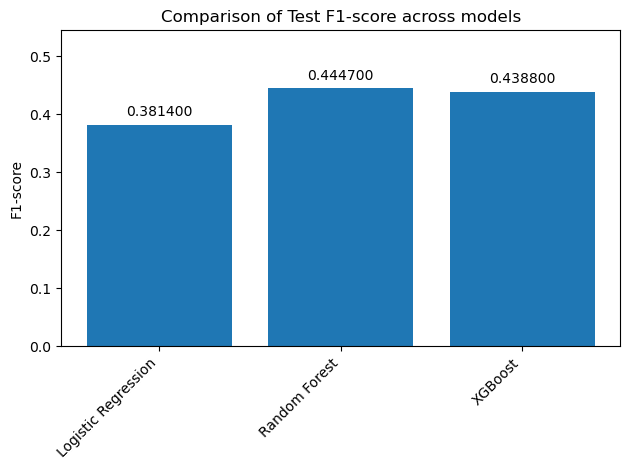

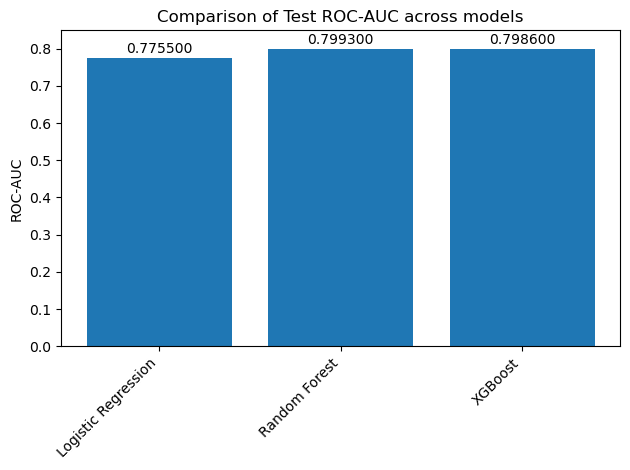

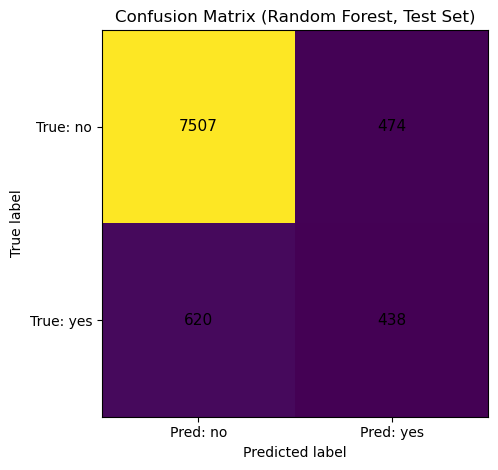

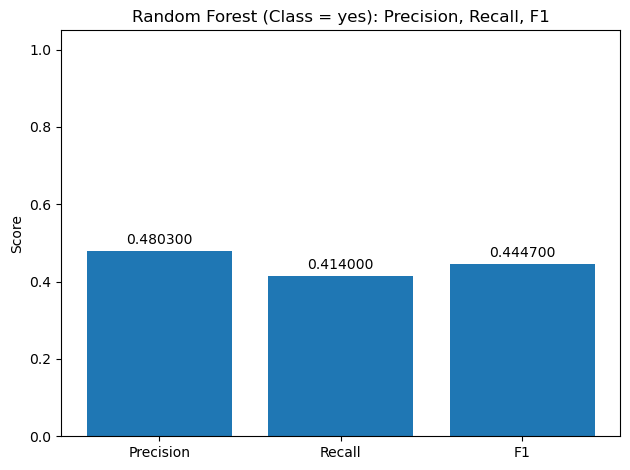

In [37]:
# ============================================================
# VISUALISATION – MODEL COMPARISON AND CONFUSION MATRIX PLOTS
# ============================================================

# ------------------------------------------------------------
# 0. HELPER FUNCTION: add numeric labels on top of bar charts
# ------------------------------------------------------------
# add_bar_labels() iterates over a collection of bar patches
# and places a formatted text label just above each bar.
#   bars  : the BarContainer returned by plt.bar()
#   fmt   : Python format string (default: 6 decimal places)
#   y_pad : vertical gap between bar top and label text
def add_bar_labels(bars, fmt="{:.6f}", y_pad=0.01):
    for b in bars:
        h = b.get_height()             # bar height = metric value
        plt.text(
            b.get_x() + b.get_width() / 2,  # centre of bar
            h + y_pad,                       # slightly above bar
            fmt.format(h),                   # formatted value
            ha="center",
            va="bottom",
            fontsize=10
        )

# ------------------------------------------------------------
# 1. RESULTS DATA
# ------------------------------------------------------------
# Hardcoded summary of CV and test metrics for each model
# (previously computed in the training cell above).
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "CV F1 (mean)":    [0.3854, 0.4487, 0.4363],
    "CV ROC-AUC (mean)": [0.7697, 0.7907, 0.7961],
    "Test F1":         [0.3814, 0.4447, 0.4388],
    "Test ROC-AUC":    [0.7755, 0.7993, 0.7986],
})

# Confusion matrix values for the best model (Random Forest, test set)
# Layout: [[TN, FP], [FN, TP]]
#   TN=7507 (correctly predicted 'no')
#   FP=474  (predicted 'yes' but actually 'no'  – false alarm)
#   FN=620  (predicted 'no'  but actually 'yes' – missed subscription)
#   TP=438  (correctly predicted 'yes')
cm = np.array([[7507, 474],
               [ 620, 438]])

# Positive-class (yes=1) metrics for Random Forest on the test set
metrics_pos = pd.Series({
    "Precision": 0.4803,   # of all predicted 'yes', 48 % were truly 'yes'
    "Recall":    0.4140,   # of all actual 'yes', 41 % were captured
    "F1":        0.4447    # harmonic mean of Precision and Recall
})

# Flag to control whether plots are saved to disk
SAVE    = False   # set True to save PNGs to OUT_DIR
OUT_DIR = "figures"
if SAVE:
    os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2. PLOT A – TEST F1 COMPARISON ACROSS MODELS
# ------------------------------------------------------------
plt.figure()
bars = plt.bar(results["Model"], results["Test F1"])
add_bar_labels(bars, fmt="{:.6f}", y_pad=0.01)   # label each bar
plt.ylabel("F1-score")
plt.title("Comparison of Test F1-score across models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, min(1.0, results["Test F1"].max() + 0.10))  # leave headroom above tallest bar
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "test_f1_comparison.png"), dpi=300)
plt.show()

# ------------------------------------------------------------
# 3. PLOT B – TEST ROC-AUC COMPARISON ACROSS MODELS
# ------------------------------------------------------------
plt.figure()
bars = plt.bar(results["Model"], results["Test ROC-AUC"])
add_bar_labels(bars, fmt="{:.6f}", y_pad=0.005)
plt.ylabel("ROC-AUC")
plt.title("Comparison of Test ROC-AUC across models")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, min(1.0, results["Test ROC-AUC"].max() + 0.05))
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "test_rocauc_comparison.png"), dpi=300)
plt.show()

# ------------------------------------------------------------
# 4. PLOT C – CONFUSION MATRIX (RANDOM FOREST)
# ------------------------------------------------------------
# imshow() renders the 2x2 matrix as a colour-coded heatmap.
# Text annotations on each cell show the raw counts.
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Random Forest, Test Set)")
plt.xticks([0, 1], ["Pred: no", "Pred: yes"])
plt.yticks([0, 1], ["True: no", "True: yes"])
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Annotate each cell with its numeric value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center", fontsize=11)

plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_random_forest.png"), dpi=300)
plt.show()

# ------------------------------------------------------------
# 5. PLOT D – POSITIVE-CLASS METRICS (RANDOM FOREST)
# ------------------------------------------------------------
# Displays Precision, Recall, and F1 for the positive class
# side-by-side, making the precision-recall trade-off visible.
plt.figure()
bars = plt.bar(metrics_pos.index, metrics_pos.values)
add_bar_labels(bars, fmt="{:.6f}", y_pad=0.01)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Random Forest (Class = yes): Precision, Recall, F1")
plt.tight_layout()
if SAVE:
    plt.savefig(os.path.join(OUT_DIR, "rf_positive_class_metrics.png"), dpi=300)
plt.show()


In [38]:
# Quick sanity check: confirm that the variable 'preprocess'
# (our ColumnTransformer) is present in the global namespace.
# If the list returns ['preprocess'], the preprocessing step
# is correctly defined and ready to be used in Pipelines.
[name for name in ["preprocess", "preprocessor", "ct", "column_transformer"]
 if name in globals()]


['preprocess']

In [40]:
# ============================================================
# FINAL MODEL – RANDOM FOREST (BEST PERFORMER)
# ------------------------------------------------------------
# After cross-validation and test evaluation, Random Forest
# achieved the highest Test F1 (0.4447) and was selected as
# the final model.
#
# We rebuild the pipeline from scratch here to provide a clean,
# self-contained cell that can be run independently.
# ============================================================

# Assemble the final pipeline: preprocessing → Random Forest
final_model = Pipeline([
    ("preprocess", preprocess),   # scale numeric, one-hot categorical
    ("model", rf)                 # Random Forest classifier
])

# Fit on the full training set
final_model.fit(X_train, y_train)

# Generate predictions on the held-out test set
y_pred  = final_model.predict(X_test)            # hard label (0 or 1)
y_proba = final_model.predict_proba(X_test)[:, 1] # P(y=1) for AUC

# Print evaluation metrics
print("Confusion matrix:\n",       confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("\nTest ROC-AUC:",            roc_auc_score(y_test, y_proba))


Confusion matrix:
 [[7507  474]
 [ 620  438]]

Classification report:
               precision    recall  f1-score   support

           0     0.9237    0.9406    0.9321      7981
           1     0.4803    0.4140    0.4447      1058

    accuracy                         0.8790      9039
   macro avg     0.7020    0.6773    0.6884      9039
weighted avg     0.8718    0.8790    0.8750      9039


Test ROC-AUC: 0.7992698395930411


# **Permutation Importance**

In [43]:
# ============================================================
# FEATURE IMPORTANCE – PERMUTATION IMPORTANCE
# ------------------------------------------------------------
# Permutation importance measures how much the model's F1 score
# drops when the values of a single feature are randomly shuffled
# (destroying its relationship with the target).
#
# A large drop → the feature is important.
# A small drop → the feature contributes little.
#
# Advantages over tree-based 'impurity importance':
#   - Model-agnostic (works with any sklearn estimator)
#   - Evaluated on the test set, so reflects generalisation
#   - Not biased towards high-cardinality features
#
# n_repeats=10: shuffle each feature 10 times and average
#   the importance to reduce variance.
# ============================================================

# Ensure the model is fitted on the full training data
final_model.fit(X_train, y_train)

# Compute permutation importance on the test set
perm = permutation_importance(
    final_model,
    X_test, y_test,
    scoring="f1",       # metric to measure the drop in
    n_repeats=10,       # repeat shuffling 10 times per feature
    random_state=42
)

# Build a summary DataFrame with mean importance and std across repeats
feature_names = X_test.columns
imp_df = pd.DataFrame({
    "feature":         feature_names,
    "importance_mean": perm.importances_mean,   # average F1 drop
    "importance_std":  perm.importances_std     # variability across repeats
}).sort_values("importance_mean", ascending=False)  # most important first

print(imp_df.head(15))   # display the 15 most important features


      feature  importance_mean  importance_std
10      month         0.079470        0.008383
8     contact         0.072867        0.006601
14   poutcome         0.055400        0.003963
6     housing         0.033791        0.005704
12      pdays         0.027263        0.003276
11   campaign         0.014112        0.004390
0         age         0.013187        0.003836
7        loan         0.010617        0.003950
5     balance         0.006614        0.004720
2     marital         0.004254        0.003520
9         day         0.001164        0.003709
13   previous         0.000269        0.001982
4     default         0.000158        0.000965
3   education        -0.001574        0.002554
1         job        -0.002296        0.005368


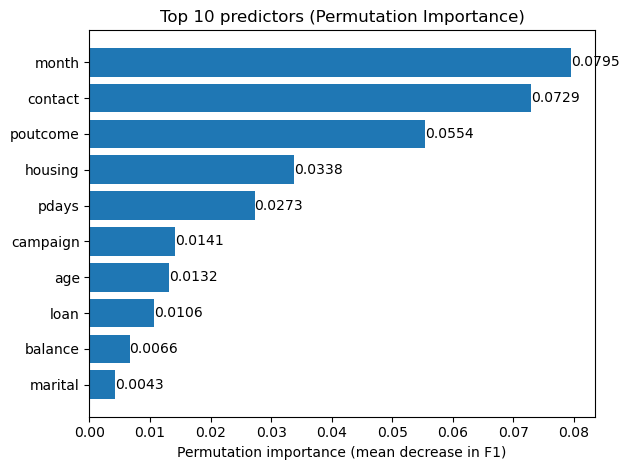

In [44]:
# ============================================================
# VISUALISATION – TOP 10 FEATURES (PERMUTATION IMPORTANCE)
# ------------------------------------------------------------
# A horizontal bar chart is used instead of vertical so that
# long feature names fit comfortably on the y-axis.
# Features are sorted ascending so the most important bar
# appears at the top of the chart.
# ============================================================

top_n = 10
top   = imp_df.head(top_n).copy()

# Sort ascending so the highest bar appears at the top
top = top.sort_values("importance_mean", ascending=True)

plt.figure()
bars = plt.barh(top["feature"], top["importance_mean"])
plt.xlabel("Permutation importance (mean decrease in F1)")
plt.title(f"Top {top_n} predictors (Permutation Importance)")

# Annotate each bar with its exact importance value
for b in bars:
    v = b.get_width()                               # importance value
    plt.text(v, b.get_y() + b.get_height()/2,       # right of bar, vertically centred
             f"{v:.4f}", va="center")

plt.tight_layout()
plt.show()


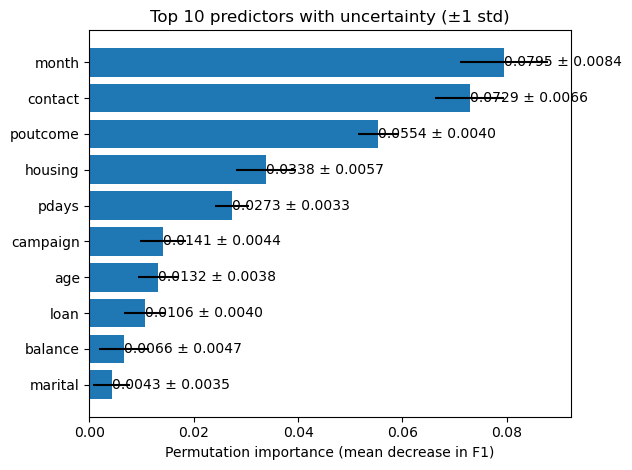

In [45]:
# ============================================================
# VISUALISATION – TOP 10 FEATURES WITH UNCERTAINTY (±1 STD)
# ------------------------------------------------------------
# Adding error bars (±1 standard deviation across the 10 shuffle
# repeats) shows how stable each importance estimate is.
# Wide error bars suggest high variance and lower reliability.
# ============================================================

top_n = 10
top   = imp_df.head(top_n).copy()
top   = top.sort_values("importance_mean", ascending=True)

plt.figure()
bars = plt.barh(
    top["feature"],
    top["importance_mean"],
    xerr=top["importance_std"]   # error bar = ±1 standard deviation
)
plt.xlabel("Permutation importance (mean decrease in F1)")
plt.title(f"Top {top_n} predictors with uncertainty (±1 std)")

# Annotate each bar with mean ± std
for i, (mean, std) in enumerate(zip(top["importance_mean"],
                                    top["importance_std"])):
    plt.text(mean, i, f"{mean:.4f} ± {std:.4f}", va="center")

plt.tight_layout()
plt.show()


In [47]:
# ============================================================
# SAVE PERMUTATION IMPORTANCE RESULTS TO CSV
# ------------------------------------------------------------
# Persist the full importance DataFrame so results can be
# inspected, reported, or compared across different runs
# without re-running the (computationally expensive)
# permutation importance calculation.
# ============================================================

import os

# Create the output directory if it does not already exist
os.makedirs("figures", exist_ok=True)

# Export all features (not just top 10) sorted by importance
imp_df.to_csv("figures/permutation_importance.csv", index=False)


# **Threshold Analysis**

In [48]:
# ============================================================
# THRESHOLD ANALYSIS – SETUP
# ------------------------------------------------------------
# By default, classifiers predict the positive class when
# P(y=1) >= 0.5 (the default decision threshold).
#
# Lowering the threshold increases recall (fewer missed
# subscriptions) at the cost of lower precision (more false
# alarms).  Raising it does the opposite.
#
# We first compute P(y=1) for every test observation, then
# sweep across thresholds to find the optimal operating point.
# ============================================================

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Refit to ensure we have a fresh, fully trained final model
final_model.fit(X_train, y_train)

# Predicted probability of positive class (yes=1) for each test row
y_prob = final_model.predict_proba(X_test)[:, 1]   # P(y=1)

# Baseline AUC at the default threshold (threshold-independent metric)
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))


Test ROC-AUC: 0.7992698395930411


In [49]:
# ============================================================
# THRESHOLD SWEEP – BUILD COMPARISON TABLE
# ------------------------------------------------------------
# We evaluate precision, recall, F1 (positive class), and the
# predicted 'yes' rate at every threshold from 0.05 to 0.95
# (step 0.05).
#
# This table helps choose a threshold aligned with business
# needs, e.g.:
#   - Maximise F1       → balanced precision/recall
#   - Minimum recall    → ensure a required fraction of
#                         subscribers is captured
#   - Control call rate → limit how many clients are contacted
# ============================================================

# Range of thresholds to evaluate
thresholds = np.arange(0.05, 0.96, 0.05)

rows = []
for t in thresholds:
    # Convert probabilities to hard labels at threshold t
    y_pred_t = (y_prob >= t).astype(int)

    rows.append({
        "threshold":          t,
        "precision_yes":      precision_score(y_test, y_pred_t, zero_division=0),
        "recall_yes":         recall_score(y_test, y_pred_t, zero_division=0),
        "f1_yes":             f1_score(y_test, y_pred_t, zero_division=0),
        # Fraction of test observations classified as 'yes'
        "predicted_yes_rate": y_pred_t.mean()
    })

thr_df = pd.DataFrame(rows)

# Display the 10 thresholds that yield the highest F1 for the positive class
print(thr_df.sort_values("f1_yes", ascending=False).head(10))


    threshold  precision_yes  recall_yes    f1_yes  predicted_yes_rate
7        0.40       0.422990    0.532136  0.471327            0.147251
8        0.45       0.463728    0.477316  0.470424            0.120478
6        0.35       0.378411    0.589792  0.461027            0.182432
9        0.50       0.480263    0.413989  0.444670            0.100896
5        0.30       0.332690    0.652174  0.440613            0.229450
10       0.55       0.513032    0.353497  0.418579            0.080651
11       0.60       0.559265    0.316635  0.404345            0.066268
4        0.25       0.278401    0.704159  0.399036            0.296050
12       0.65       0.602174    0.261815  0.364954            0.050891
3        0.20       0.222313    0.774102  0.345424            0.407567


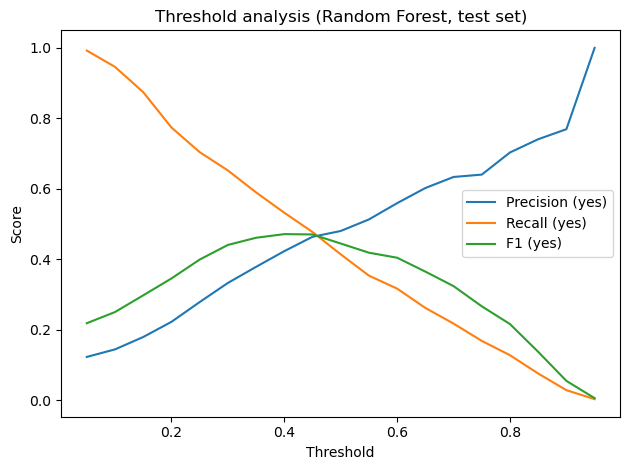

In [50]:
# ============================================================
# VISUALISATION – PRECISION / RECALL / F1 vs. THRESHOLD
# ------------------------------------------------------------
# Plotting all three metrics against the decision threshold
# on a single axes makes the precision-recall trade-off
# immediately visible and helps choose an operating point.
#
# Typical observations:
#   - As threshold decreases: recall rises, precision falls
#   - F1 peaks at the optimal balance between the two
# ============================================================

plt.figure()
plt.plot(thr_df["threshold"], thr_df["precision_yes"], label="Precision (yes)")
plt.plot(thr_df["threshold"], thr_df["recall_yes"],    label="Recall (yes)")
plt.plot(thr_df["threshold"], thr_df["f1_yes"],        label="F1 (yes)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold analysis (Random Forest, test set)")
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
# ============================================================
# SELECT OPTIMAL THRESHOLD – MAXIMISE F1 (POSITIVE CLASS)
# ------------------------------------------------------------
# idxmax() returns the row index where f1_yes is highest.
# This threshold gives the best balance between precision and
# recall for the minority class (yes = subscribed).
# ============================================================

# Find the row with the highest F1 score for the positive class
best_row = thr_df.loc[thr_df["f1_yes"].idxmax()]
best_t   = float(best_row["threshold"])   # extract threshold value as a float

print("Best threshold by F1:", best_t)
print(best_row)


Best threshold by F1: 0.4
threshold             0.400000
precision_yes         0.422990
recall_yes            0.532136
f1_yes                0.471327
predicted_yes_rate    0.147251
Name: 7, dtype: float64


In [52]:
# ============================================================
# SELECT THRESHOLD SUBJECT TO A MINIMUM RECALL CONSTRAINT
# ------------------------------------------------------------
# In marketing, missing a potential subscriber (false negative)
# may be more costly than contacting someone who won't subscribe
# (false positive).  We therefore look for the threshold that
# achieves at least target_recall = 60 % recall while
# maximising precision among those candidates.
#
# Adjust target_recall to match the business requirement.
# ============================================================

# Minimum acceptable recall for the positive class
target_recall = 0.60

# Filter to rows that meet the recall floor, then rank by
# precision (highest first) to find the most precise option
candidates = (
    thr_df[thr_df["recall_yes"] >= target_recall]
    .sort_values("precision_yes", ascending=False)
)
print(candidates.head(10))


   threshold  precision_yes  recall_yes    f1_yes  predicted_yes_rate
5       0.30       0.332690    0.652174  0.440613            0.229450
4       0.25       0.278401    0.704159  0.399036            0.296050
3       0.20       0.222313    0.774102  0.345424            0.407567
2       0.15       0.179264    0.874291  0.297523            0.570860
1       0.10       0.144132    0.946125  0.250156            0.768337
0       0.05       0.122707    0.992439  0.218409            0.946676
